# Проект "Прогнозирование оттока клиентов"

### Оглавление

* [Вступление](#id_1)
 * [Задача проекта](#id_1a)
 * [Описание данных](#id_1b)
 * [Библиотеки и путь к данным](#id_1c)
* [Исследовательский анализ данных](#id_2)
 * [Гистограммы колонок таблицы данных](#id_2a)
 * [ Сравнение средних значений параметров по значению параметра churn](#id_2b)
 * [Выявление аномальных значений](#id_2c)
 * [Создание очищенной от выбросов таблицы данных](#id_2d)
 * [Диаграмма корреляции между параметрами очищенной таблицы данных](#id_2e)
 * [Анализ значений посетителей, разбитых по значению поля churn](#id_2f)
* [Постройка модели прогнозирования оттока клиентов](#id_3)
 * [Создание таблиц данных для моделей](#id_3a)
 * [Модель логистической регрессии](#id_3b)
 * [Модель случайного леса](#id_3c)
* [Кластеризация клиентов на основе алгоритма K-means](#id_4)
 * [Нормализация данных](#id_4a)
 * [Построение дендрограммы](#id_4b)
 * [Расчет значений кластеров и метрики silhouette_score](#id_4c)
 * [ Вывод статистики по средним значениям  признаков по кластеру](#id_4d)
 * [Диаграмма распределения признаков по кластерам](#id_4e)
* [Выводы и рекомендации по снижению параметра оттока клиентов](#id_5)

## Вступление <a class="anchor" id="id_1"></a> 

### Задача проекта <a class="anchor" id="id_1a"></a> 

Провести анализ и подготовить план действий по удержанию клиентов. А именно:   
 - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
     1) выделить целевые группы клиентов;  
     2) предложить меры по снижению оттока;  
     3) определить другие особенности взаимодействия с клиентами.  

### Описание данных <a class="anchor" id="id_1b"></a> 

Данные клиента за предыдущий до проверки факта оттока месяц:    
**'gender'** — пол;  
**'Near_Location'** — проживание или работа в районе, где находится фитнес-центр;  
**'Partner'** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
**Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
**'Phone'** — наличие контактного телефона;  
**'Age'** — возраст;  
**'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах). 

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
**'Contract_period'** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
**'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах);  
**'Group_visits'** — факт посещения групповых занятий;    
**'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента;  
**'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц;  
**'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
**'Churn'** — факт оттока в текущем месяце.

### Библиотеки и путь к данным <a class="anchor" id="id_1с"></a> 

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
plt.style.use('seaborn-white')
import random
import warnings
warnings.filterwarnings('ignore')
#Импорт моделей
from sklearn.model_selection import train_test_split #импорт средств разбиения данных на выборки
from sklearn.preprocessing import StandardScaler # импорт средств стандартизации данных
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # импорт метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression # модель логистической регрессии
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier #модель случайного леса
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans # модель K-means
from scipy.cluster.hierarchy import dendrogram, linkage # средства работы с алгоритмом K-means
# импорт метрик
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

## Исследовательский анализ данных <a class="anchor" id="id_2"></a> 

In [345]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [346]:
display (data.head())
display(data.info())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Таблица данных содержит 14 колонок и 4000 строчек, пропусков нет.  
Можно привести имена колонок к нижнему регистру, чтобы они выглядели единообразно.

In [347]:
def column_name_formatter (name):
    name_lowercase = name.lower()    
    return name_lowercase

In [348]:
data.columns = map(column_name_formatter, data.columns)
print(data.columns.values)

['gender' 'near_location' 'partner' 'promo_friends' 'phone'
 'contract_period' 'group_visits' 'age' 'avg_additional_charges_total'
 'month_to_end_contract' 'lifetime' 'avg_class_frequency_total'
 'avg_class_frequency_current_month' 'churn']


Колонки со значениями не 0 или 1:

In [349]:
non_binary_columns = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

### Гистограммы колонок таблицы данных <a class="anchor" id="id_2a"></a>

Гистограммы по всей таблице:

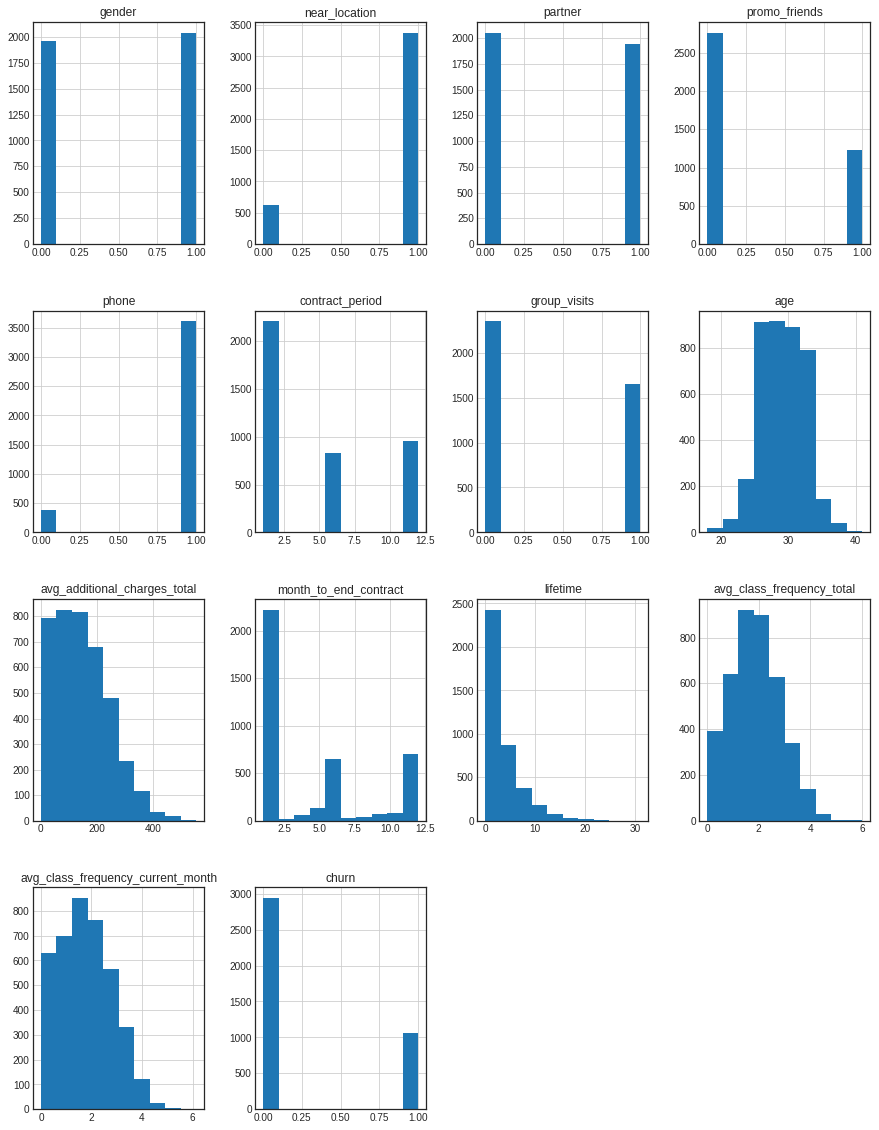

In [350]:
data.hist(figsize=(15,20))
plt.show()

<span style="font-size:12px">    
Описание данных.<br>    
Данные клиента за предыдущий до проверки факта оттока месяц:
    
**gender** — пол;    
**Near_Location** — проживание или работа в районе, где находится фитнес-центр;    
**Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);    
**Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);    
**'Phone'** — наличие контактного телефона;    
**'Age'** — возраст;    
**Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах). 

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
**'Contract_period'** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
**'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах);  
**'Group_visits'** — факт посещения групповых занятий;    
**'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента;  
**'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц;  
**'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
**'Churn'** — факт оттока в текущем месяце.</span>

In [351]:
display(data.describe().round(3))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.51,0.845,0.487,0.308,0.904,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.50,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.00,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.00,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.00,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.00,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.00,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


Из вышеприведенного графика можно увидеть, что:
 - женщин и мужчин примерно поровну, последних чуть больше.
 - по возрасту, подавляющее большинство участников имеют от 25 до 35 лет, минимальный -18 лет, максимальный - 41 год.
 - примерно 85% людей проживают или работают в одном районе с фитнесс-центром.
 - партнеров и не партнеров примерно поровну, последних чуть меньше.
 - примерно 30% людей записались в центры по промо-акциям "Приведи друга".
 - 90% людей указали свой телефон.
 - Более половины (около 2300) участников посещают фитнесс-центры по месячному абонементу, чуть менее 1000 - по годовому абонементу, остальные - по шестимесячному.
 - Большинство предпочитают групповые занятия
 - Средний дополнительный доход фитнесс-центра у 75% у посетителей равен 211 рублям, максимальное значение 552 рубля.
 - Более половины (около 2400) людей имеют абонемент, который закончится в следующем месяце, среднее количество месяцев до окончания абонемента - 4.3 месяца.
 - 50% посетителей прекращают занятия после 3 месяцев, среднее значение по всем данным - 3.7 месяцев.
 - 2 или 3 посещения в неделю - самые распространенное количество посещений в неделю, причем по графикам "avg_class_frequency_total" и	"avg_class_frequency_current_month" не заметно, чтобы характер посещений заметно менялся в последнем месяце посещения спортзала.
 - Среднее значение оттока посетителей в месяц составляет 26%.
 

### Сравнение средних значений параметров по значению параметра churn <a class="anchor" id="id_2b"></a>

In [352]:
display(data.groupby('churn').mean().T.assign(difference_percent = (
    data.groupby('churn').mean().T[1]-data.groupby('churn').mean().T[0])/(data.groupby('churn').mean().T[0]) *100
                                             ).sort_values('difference_percent', ascending = True)
       )

churn,0,1,difference_percent
lifetime,4.711807,0.990575,-78.976750
contract_period,5.747193,1.728558,-69.923439
month_to_end_contract,5.283089,1.662582,-68.530110
avg_class_frequency_current_month,2.027882,1.044546,-48.490803
promo_friends,0.353522,0.183789,-48.011981
group_visits,0.464103,0.268615,-42.121843
partner,0.534195,0.355325,-33.484034
avg_additional_charges_total,158.445715,115.082899,-27.367617
avg_class_frequency_total,2.024876,1.474995,-27.156284
near_location,0.873086,0.768143,-12.019757


Наибольшие изменения видны у параметров lifetime, contract_period( и связанным с ним параметром month_to_end_contract), avg_class_frequency_current_month, promo_friends, group_visits.  
Изменения отрицательные и можно сказать что:
- посетители фитнесс-центров, которые прекратили занятия, ходили недавно (имели короткий Lifetime, около месяца), 
- имели месячные абонементы, 
- они реже были участниками промо-кампаний "приведи друга", 
- они реже были участниками групповых занятий или работниками организаций, с которыми у центра были заключены партнерские соглашения,
- также они приносили на 30% средних дополнительных доходов.

### Выявление аномальных значений <a class="anchor" id="id_2c"></a>

Обнаружение аномальных значений: для этого использую метод из библиотеки Numpy percentile() и за аномальные значения приму значения выше 99 персентиля.

In [353]:
for column in non_binary_columns:
    print(column, ': ', np.percentile(data[column], [95, 99]))

contract_period :  [12. 12.]
age :  [34. 37.]
avg_additional_charges_total :  [323.44087589 400.99612505]
month_to_end_contract :  [12. 12.]
lifetime :  [11. 17.]
avg_class_frequency_total :  [3.53564837 4.19757925]
avg_class_frequency_current_month :  [3.54906154 4.18575779]


In [354]:
#вспомогательная функция для определения границ разброса значений
def get_swipe_range(dataset):
    
    median = pd.DataFrame.median(dataset)
    mean = pd.DataFrame.mean(dataset)
    min_value =  pd.DataFrame.min(dataset)
    max_value = pd.DataFrame.max(dataset)
    quartile_1 = pd.DataFrame(dataset).quantile(0.25,numeric_only=False)
    quartile_3 = pd.DataFrame(dataset).quantile(0.75,numeric_only=False)
    # Interquartile range
    iqr = round(quartile_3-quartile_1,2)
    #Вычисление границ размаха
    left_swipe_value = round(quartile_1-1.5*iqr,2)
    right_swipe_value = round(quartile_3+1.5*iqr,2)    
    print('Границы разброса значений для колонки:',dataset.name)         
    print('Левое значение: %s' % left_swipe_value.to_string())
    print('Правое значение: %s' % right_swipe_value.to_string())

In [355]:
for name in non_binary_columns:
    get_swipe_range(data[name])
    print('-'*20)

Границы разброса значений для колонки: contract_period
Левое значение: contract_period   -6.5
Правое значение: contract_period    13.5
--------------------
Границы разброса значений для колонки: age
Левое значение: age    21.0
Правое значение: age    37.0
--------------------
Границы разброса значений для колонки: avg_additional_charges_total
Левое значение: avg_additional_charges_total   -144.25
Правое значение: avg_additional_charges_total    424.07
--------------------
Границы разброса значений для колонки: month_to_end_contract
Левое значение: month_to_end_contract   -6.5
Правое значение: month_to_end_contract    13.5
--------------------
Границы разброса значений для колонки: lifetime
Левое значение: lifetime   -5.0
Правое значение: lifetime    11.0
--------------------
Границы разброса значений для колонки: avg_class_frequency_total
Левое значение: avg_class_frequency_total   -0.86
Правое значение: avg_class_frequency_total    4.58
--------------------
Границы разброса значений д

**Вывод:** за аномальные данные я принял решение считать записи, если:
 - возраст меньше 21 и больше 37 лет;
 - значение avg_additional_charges_total больше 424 рублей;
 - значение avg_class_frequency_total больше 4.58;
 - значение avg_class_frequency_current_month больше 4.84;
 - значение Lifetime больше  11 месяцев;
 - значение month_to_end_contract больше 13.5

### Создание очищенной от выбросов таблицы данных <a class="anchor" id="id_2d"></a>

In [356]:
good_data = (
    data.query('age >= 21 and age <= 37')
    .query('avg_additional_charges_total <= 424')
    .query('avg_class_frequency_total <= 4.58')
    .query('avg_class_frequency_current_month <= 4.84')
    .query('month_to_end_contract <= 13.5')
    .query('lifetime <= 11')
            )

Сравнение размеров старой и очищенной таблиц:

In [357]:
print(good_data.shape[0] / data.shape[0])
print('Количество записей в очищенной таблице данных: ', good_data.shape[0])

0.93375
Количество записей в очищенной таблице данных:  3735


### Диаграмма корреляции между параметрами очищенной таблицы данных <a class="anchor" id="id_2e"></a>

График корреляции между данными:

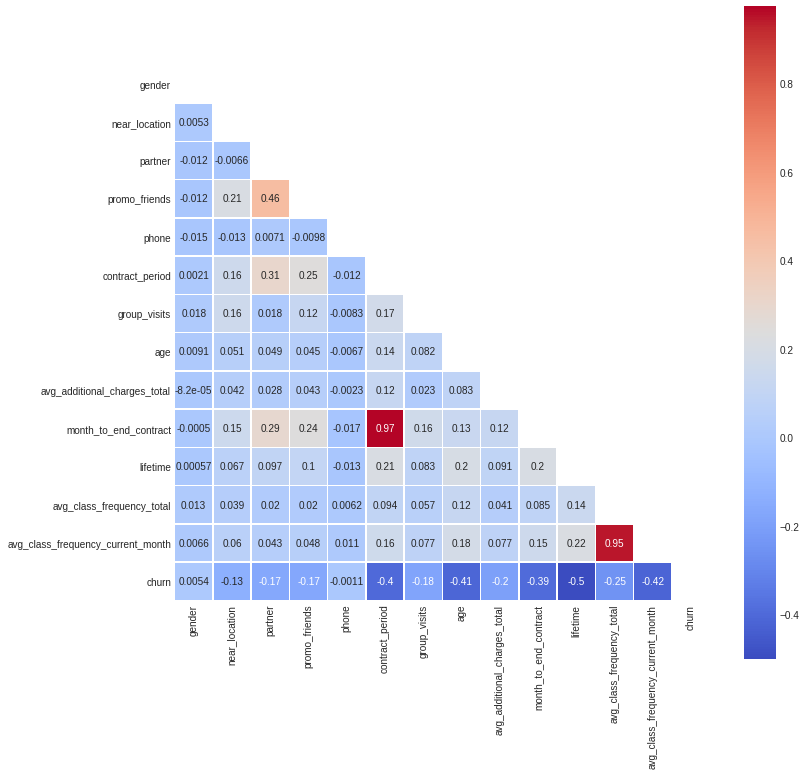

In [358]:
plt.figure(figsize=(12,12))
corr =  good_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot = True, fmt='.2g', cmap= 'coolwarm', linewidths=.5, mask=mask, square = True)
plt.show()

Справочная информация по нашим данным:    
    
1. **gender** - среднее одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
2. **Near_Location** (проживание или работа в районе, где находится фитнес-центр) - высокий показатель в обоих группах (больше "не оттока" среди тех, кто проживает и работает рядом с фитнесом). Соответственно, отток больше у тех, кто живет дальше. Можно сказать, что бинарный признак "близости к фитнесу" чуть слабее влияет на отток (чуть сильнее на то, чтобы клиент остался с нами);
    
3. **Partner** - это поле демонстрирует положительное влияние на клиентов (среди партнеров оттток меньше);
    
4. **Promo_friends** - это поле демонстрирует положительное влияние на клиентов (среди тех кто воспользовался промо оттток меньше);
    
5. **Phonе** - среднее одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
6. **Contract_period** (длительность текущего действующего абонемента (в месяцах): 1..6..12) - значительное положительное влияние на клиентов с простым объяснением (купили "длинный" абонемент, деньги терять жалко, будем заниматься);
    
7. **Group_visits** - это поле демонстрирует положительное влияние на клиентов (среди любителей посещать групповые занятия оттток меньше);
    
8. **Age** - среднее практически одинаково, следовательно, признак не влияет на отток (с его помощью не удастся "растащить" данные по группам);
    
9. **Avg_additional_charges_total** (суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон) - небольшое положительное влияние на клиентов (возможно если мы лояльны к фитнесу, то также лояльно относимся и к дополнительным услугам, которые в совокупности образуют экосистему здорового образа жизни);
    
10. **Month_to_end_contract** (срок до окончания текущего действующего абонемента (в месяцах): 1..6..12) - сильное положительное влияние на клиентов (чем больше срок действия моего абонемента - тем вероятнее, что я буду оставаться клиентом центра (возможно жалко "терять" абонемент);
    
11. **Lifetime** (время с момента первого обращения в фитнес-центр (в месяцах): 0..3..31) - очень сильное положительное влияние на клиентов (объяснение: со временем вырабатывается привычка);
    
12. **Avg_class_frequency_total** (средняя частота посещений в неделю за все время с начала действия абонемента) - положительное влияние на клиентов (чем чаще хожу заниматься, тем более мотивирован, очевидно);

13. **Avg_class_frequency_current_month** (средняя частота посещений в неделю за предыдущий месяц) - положительное влияние на клиентов с простым объяснением (чем чаще за неделю клиент ходил в фитнес в ближайщий период, тем привычка сильнее).
</div>


 Значение	 корреляции:
 от 0 до 0,3	очень слабая,
 от 0,3 до 0,5	слабая,
 от 0, 5 до 0,7	средняя,
 от 0,7 до 0, 9	высокая,
 от 0,9 до 1	очень высокая

Мультиколлинеарными признаками будут пары: month_to_end_contract - contract_period, avg_class_frequency_total - avg_class_frequency_last_month.
Есть "нулевые" признаки, которые не влияют на churn: phone, gender.

### Анализ значений посетителей, разбитых по значению поля "churn" <a class="anchor" id="id_2f"></a>

Распределение значений для ушедших посетителей:

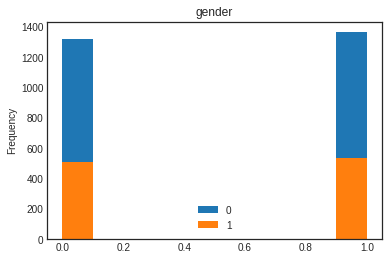

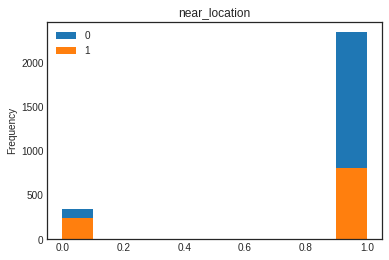

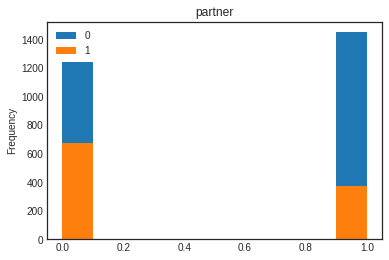

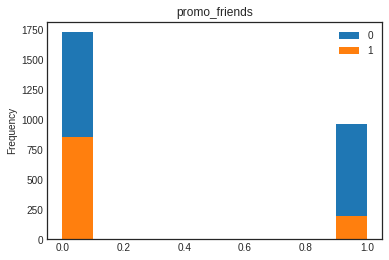

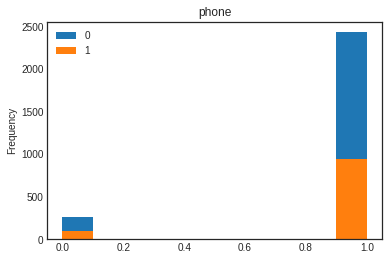

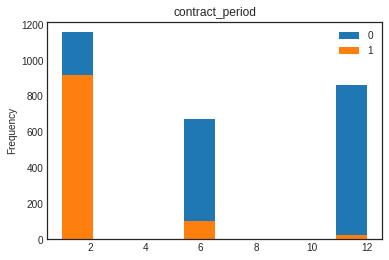

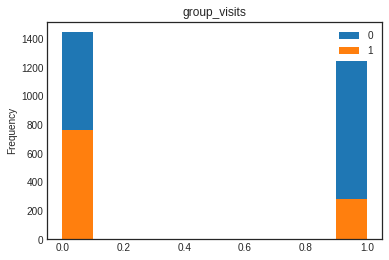

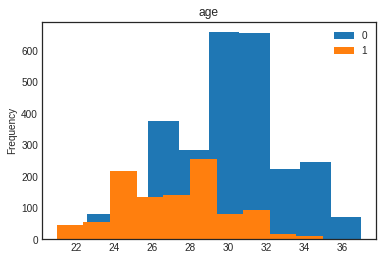

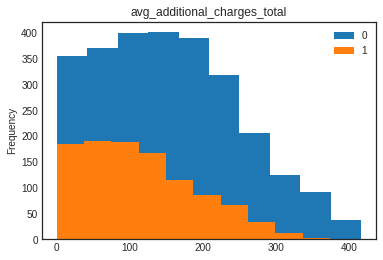

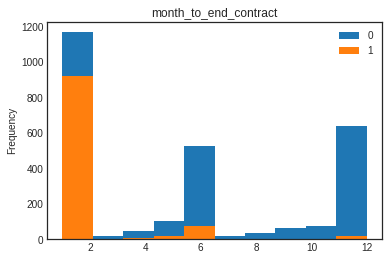

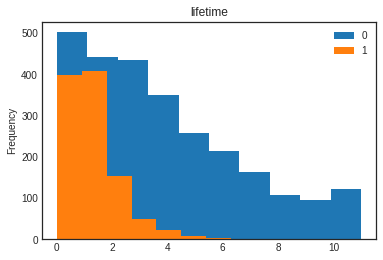

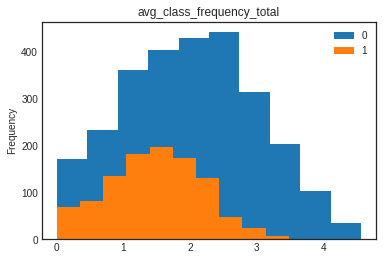

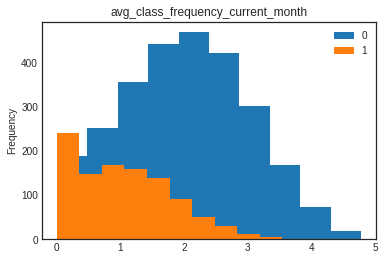

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [359]:
[good_data.groupby('churn')[i].plot(kind='hist',title=i)[0] and plt.legend() and plt.show() for i in good_data.columns[:-1]]

Из графиков можно сделать следующие выводы о том, как изменилось распределение относительно параметра churn: 
 -  среди партнеров меньше прекративших занятия;
 - существенно меняется распредление в сторону 1-2 месяца у параметра contract_period;
 - относительно возраста распределение немного смещается в сторону меньших значений;
 - по параметру lifetime также заметно сильно изменение распределения в сторону 1-2 месяца, для прекративших занятия максимальный срок абонемента равен 6 месяцам;
 - также заметно сильное искажение распределения по параметру avg_class_frequency_current_month: те, кто планировал прекратить занятия, занимались  0 -1 раз в последний месяц вместо 2-3 у остающихся.

## Постройка модели прогнозирования оттока клиентов <a class="anchor" id="id_3"></a>

Так как моей задачей является ответ на вопрос уйдет ли посетитель в следующем месяце или нет, то подходящими моделями для этого будут модели бинарной классификации - логистическая регрессия и случайный лес.

Прежде чем построить  модель машинного обучения, следует ответить на вопросы:  
- достаточно ли  большая выборка?
- насколько качественные данные?
- способна ли  модель дать правдоподобный прогноз?

Минимальная выборка может быть рассчитана по формуле $s = k * n$ , где n — число признаков для каждого наблюдения, а k — коэффициент, который из опыта часто считают равным 10. Для моей выборки $s = 10*13 = 130$, а имеются 3735 записей. Поэтому количество данных достаточно для построения модели.

Для улучшения качества модели следует удалить один признак из каждой пары обнаруженных мультиколлинеарных признаков: я принял решение удалить признаки contract_period  и avg_class_frequency_total, таким образом останутся только те признаки, которые определяют поведение посетителя в последний месяц пользования услугами фитнесс-центра.
 

In [360]:
good_data = good_data.drop(['contract_period','avg_class_frequency_total'], axis = 1)
display(good_data.head())

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.000000,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.910244,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.736502,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.120078,0


Что касается нулевых признаков, то я принял решение пока не удалять их для модели логистической регрессии, а сравнить ее качество с ними и без них.  
Так как в моделях будут очищенные от выбросов и мультиколлинеарных признаков данные, имеющие корреляцию с целевой переменной, то модель может дать правдоподобный ответ.

### Создание таблиц данных для моделей <a class="anchor" id="id_3a"></a>

In [361]:
#данные для логистической регрессии
LR_data_wo_zeroes = good_data.drop(['phone','gender'], axis = 1)
LR_data_with_zeroes = good_data.copy(deep=True)
#данные для модели случайного леса
RF_data = good_data.copy(deep=True)

In [362]:
display(LR_data_wo_zeroes.head(), LR_data_with_zeroes.head(), RF_data.head())

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,29,14.227470,5.0,3,0.000000,0
1,1,0,0,1,31,113.202938,12.0,7,1.910244,0
2,1,1,0,0,28,129.448479,1.0,2,1.736502,0
3,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,0,26,198.362265,1.0,3,1.120078,0


,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.000000,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.910244,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.736502,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.120078,0


,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.000000,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.910244,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.736502,0
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.120078,0


### Модель логистической регрессии <a class="anchor" id="id_3b"></a>

#### Cоздание обучающей, тестовой и валидационной выборок

Разделение данных на признаки (матрица X) и целевую переменную (y):

In [363]:
# для данных без нулевых признаков:
LR_wz_X = LR_data_wo_zeroes.drop(['churn'], axis =1)
LR_wz_y = LR_data_wo_zeroes['churn']
# для данных с нулевыми признаками
LR_X = LR_data_with_zeroes.drop(['churn'], axis =1)
LR_y = LR_data_with_zeroes['churn']

Создание выборок:

In [364]:
# для данных без нулевых признаков:
LR_wz_X_train, LR_wz_X_test, LR_wz_y_train, LR_wz_y_test = train_test_split(LR_wz_X, LR_wz_y, 
                                                                            test_size=0.2,
                                                                            random_state=0)
# для данных с нулевыми признаками:
LR_X_train, LR_X_test, LR_y_train, LR_y_test = train_test_split(LR_X, LR_y, test_size=0.2, random_state=0)

In [365]:
print('Количестов строе в обучающей выборке: ', LR_X_train.shape[0],
      '\nКоличество строк в тестовой выборке: ', LR_X_test.shape[0])
print(LR_X_test.shape[0]/LR_X_train.shape[0])

Количестов строе в обучающей выборке:  2988 
Количество строк в тестовой выборке:  747
0.25


#### Обучение модели для данных без нулевых признаков

In [366]:
# задание  алгоритма для  модели
LR_wz_model = LogisticRegression(solver='liblinear')

# обучение модели
LR_wz_model.fit(LR_wz_X_train, LR_wz_y_train)

# расчет прогнозов
predictions_wz = LR_wz_model.predict(LR_wz_X_test)
probabilities_wz = LR_wz_model.predict_proba(LR_wz_X_test)[:,1] 
#Коэффициенты
LR_wz_coef = LR_wz_model.coef_[0]
LR_wz_zero_coef = LR_wz_model.intercept_

Вывод метрик для модели:

In [367]:
print('Accuracy: {:.2f}'.format(accuracy_score(LR_wz_y_test, predictions_wz)))
print('Precision: {:.2f}'.format(precision_score(LR_wz_y_test, predictions_wz)))
print('Recall: {:.2f}'.format(recall_score(LR_wz_y_test, predictions_wz)))
print('F1: {:.2f}'.format(f1_score(LR_wz_y_test, predictions_wz)))

Accuracy: 0.89
Precision: 0.81
Recall: 0.78
F1: 0.80


#### Обучение модели для данных c нулевыми признаками

In [368]:
# задание  алгоритма для  модели
LR_model = LogisticRegression(solver='liblinear')

# обучение модели
LR_model.fit(LR_X_train, LR_y_train)

# расчет предсказаний
predictions_lr = LR_model.predict(LR_X_test)
probabilities_lr = LR_model.predict_proba(LR_X_test)[:,1] 
#Коэффициенты
LR_coef = LR_model.coef_[0]
LR_zero_coef = LR_model.intercept_

Вывод метрик для модели:

In [369]:
print('Accuracy: {:.2f}'.format(accuracy_score(LR_y_test, predictions_lr)))
print('Precision: {:.2f}'.format(precision_score(LR_y_test, predictions_lr)))
print('Recall: {:.2f}'.format(recall_score(LR_y_test, predictions_lr)))
print('F1: {:.2f}'.format(f1_score(LR_y_test, predictions_lr)))

Accuracy: 0.90
Precision: 0.82
Recall: 0.81
F1: 0.81


Вызов матрицы ошибок:

In [370]:
cm = confusion_matrix(LR_y_test,predictions_lr)
# "выпрямляем" матрицу, чтобы вытащить нужные значения
tn, fp, fn, tp = cm.ravel() 
print('TN: ', tn, '\nFP: ', fp, '\nFN: ', fn, '\nTP: ', tp )

TN:  514 
FP:  36 
FN:  38 
TP:  159


Большая часть прогнозов попадает в группы TN и TP, значит модель ведет себя правильно.

In [371]:
LR_metrics = {'Accuracy':accuracy_score(LR_y_test, predictions_lr).round(3),
             'Precision':precision_score(LR_y_test, predictions_lr).round(3),
             'Recall':recall_score(LR_y_test, predictions_lr).round(3),
             'F1':f1_score(LR_y_test, predictions_lr).round(3)
             }

**Вывод**: модель с данными, включающими нулевые признаки, имеет лучшие метрики, чем модель без этих признаков, поэтому лучше такие признаки не удалять.

Вывод рассчитанных коэффициентов для признаков:

In [372]:
print('Коэффициенты для данных c нулевыми признаками: ',LR_coef,
      '\nНулевой коэффициент для данных с нулевыми признаками: ', LR_zero_coef)

Коэффициенты для данных c нулевыми признаками:  [ 0.2393132   0.08580335 -0.05999668 -0.43449726  0.21309504 -0.76098464
 -0.20345123 -0.00509761 -0.29355938 -0.94155989 -1.06083469] 
Нулевой коэффициент для данных с нулевыми признаками:  [9.94396741]


#### Создание таблицы признаков и коэффициентов

Так как логистическая регрессия имеет дело с шансами, что значение принадлежит к классу 1 или 0 и использует экспоненту, чтобы коэффициенты имели смысл, их нужно привести к виду $y = e^x$, где x - значение коэффициента, с помощью функции np.exp()

In [373]:
LR_features = pd.DataFrame({'Признак':LR_X.columns,
                            'Коэффициенты для модели с нулевыми признаками':np.exp(LR_coef).round(3)})# 
display(LR_features.sort_values('Коэффициенты для модели с нулевыми признаками', ascending = False))

,Признак,Коэффициенты для модели с нулевыми признаками
0,gender,1.270
4,phone,1.238
1,near_location,1.090
7,avg_additional_charges_total,0.995
2,partner,0.942
6,age,0.816
8,month_to_end_contract,0.746
3,promo_friends,0.648
5,group_visits,0.467
9,lifetime,0.390


Создание новой колонки для значений колонки 'Коэффициенты для модели с нулевыми признаками' меньше 1, так как они имеют обратный смысл.

In [374]:
LR_features.loc[LR_features['Коэффициенты для модели с нулевыми признаками']<1,
                'Шансы оказаться в классе 1 менее вероятны'] = (
    1/LR_features['Коэффициенты для модели с нулевыми признаками']
).round(3)

In [375]:
display(LR_features.sort_values('Коэффициенты для модели с нулевыми признаками', ascending = False))

,Признак,Коэффициенты для модели с нулевыми признаками,Шансы оказаться в классе 1 менее вероятны
0,gender,1.270,NaN
4,phone,1.238,NaN
1,near_location,1.090,NaN
7,avg_additional_charges_total,0.995,1.005
2,partner,0.942,1.062
6,age,0.816,1.225
8,month_to_end_contract,0.746,1.340
3,promo_friends,0.648,1.543
5,group_visits,0.467,2.141
9,lifetime,0.390,2.564


**Вывод**: при увеличении значения параметра phone на 1, шансы, что человек окажется в классе в 1.24 раз больше, чем шансы оказаться в классе 0. И при увеличении значения Lifetime на 1, шансы, что человек окажется в классе 1 в 2.9 раз меньше, чем оказаться в классе 0.

### Создание модели RandomForest <a class="anchor" id="id_3c"></a>

#### Создание обучающей, тестовой и валидационной выборок

Так как этот алгоритм не основан на расстояниях, то нормализация данных не требуется.

In [376]:
#Разделение данных на признаки (матрица X) и целевую переменную (y)
RF_X = RF_data.drop(['churn'], axis =1)
RF_y = RF_data['churn']

In [377]:
#Создание выборок
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(RF_X, RF_y, test_size=0.2, random_state=0)

In [378]:
#Алгоритм для модели на основе алгоритма случайного леса
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# Обучение модели
RF_model.fit(RF_X_train, RF_y_train)
# Вычисление прогнозов
RF_predictions = RF_model.predict(RF_X_test)
RF_probabilities = RF_model.predict_proba(RF_X_test)[:,1]

In [379]:
print('Accuracy: {:.3f}'.format(accuracy_score(RF_y_test, RF_predictions)))
print('Precision: {:.3f}'.format(precision_score(RF_y_test, RF_predictions)))
print('Recall: {:.3f}'.format(recall_score(RF_y_test, RF_predictions)))
print('F1: {:.3f}'.format(f1_score(RF_y_test, RF_predictions)))

Accuracy: 0.890
Precision: 0.814
Recall: 0.756
F1: 0.784


Вызов матрицы ошибок:

In [380]:
cm = confusion_matrix(RF_y_test,RF_predictions)
# "выпрямляем" матрицу, чтобы вытащить нужные значения
tn, fp, fn, tp = cm.ravel() 
print('TN: ', tn, '\nFP: ', fp, '\nFN: ', fn, '\nTP: ', tp )

TN:  516 
FP:  34 
FN:  48 
TP:  149


Модель ведет себя правильно, но немного перестраховывается.

Сохранение метрик в словарь:

In [381]:
RF_metrics = {'Accuracy':accuracy_score(RF_y_test, RF_predictions).round(3),
             'Precision':precision_score(RF_y_test, RF_predictions).round(3),
             'Recall':recall_score(RF_y_test, RF_predictions).round(3),
             'F1':f1_score(RF_y_test, RF_predictions).round(3)
             }

Вывод дефолтных параметров, с которыми работал алгоритм:

In [382]:
print(RF_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


#### Улучшение модели

Так как нужно обнаружить как можно больше объектов класса 1, то самой важной является метрика Recall, поэтому улучшение модели будет направлено на ее увеличение.  
Для этого я создам массивы значений ключевых параметров модели: *n_estimators*, *max_depth* и *min_samples_split*. Затем, используя цикл по одному параметру, буду вычислять наибольшее значение метрики Recall и заносить его в словарь, а также другие метрики.
После этого будет подбираться следующий параметр из трех.

Подборка тестовых параметров:

In [383]:
max_depths = list(range(1,33))
n_estimators = list(range(10,310,10))
min_samples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [384]:
#Создание и инициализация словаря метрик
metrics_dict = {'N_estimator':0, 'Max_depth':0, 'Accuracy':0, 'Precision':0, 'Recall':0, 'F1':0}
for n in n_estimators:
        RF_model = RandomForestClassifier(n_estimators = n,  random_state = 0) 
        RF_model.fit(RF_X_train, RF_y_train)
        RF_predictions = RF_model.predict(RF_X_test)
        RF_probabilities = RF_model.predict_proba(RF_X_test)[:,1]
        if  recall_score(RF_y_test, RF_predictions).round(3) > metrics_dict['Recall']:
            metrics_dict['Accuracy'] = accuracy_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Recall'] = recall_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Precision'] = precision_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['F1'] = f1_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['N_estimator'] = n           
print(metrics_dict)

{'N_estimator': 160, 'Max_depth': 0, 'Accuracy': 0.897, 'Precision': 0.83, 'Recall': 0.766, 'F1': 0.797}


In [385]:
for max_depth in max_depths:
        RF_model = RandomForestClassifier(n_estimators = metrics_dict['N_estimator'], 
                                          max_depth = max_depth,  
                                          random_state = 0) 
        RF_model.fit(RF_X_train, RF_y_train)
        RF_predictions = RF_model.predict(RF_X_test)
        RF_probabilities = RF_model.predict_proba(RF_X_test)[:,1]
        if recall_score(RF_y_test, RF_predictions).round(3) > metrics_dict['Recall']:
            metrics_dict['Accuracy'] = accuracy_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Recall'] = recall_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Precision'] = precision_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['F1'] = f1_score(RF_y_test, RF_predictions).round(3)            
            metrics_dict['Max_depth'] = max_depth  
print(metrics_dict)

{'N_estimator': 160, 'Max_depth': 14, 'Accuracy': 0.898, 'Precision': 0.831, 'Recall': 0.772, 'F1': 0.8}


In [386]:
for min_sample in min_samples:
        RF_model = RandomForestClassifier(n_estimators = metrics_dict['N_estimator'],
                                          max_depth = metrics_dict['Max_depth'],
                                          min_samples_split = min_sample,
                                          random_state = 0) 
        RF_model.fit(RF_X_train, RF_y_train)
        RF_predictions = RF_model.predict(RF_X_test)
        RF_probabilities = RF_model.predict_proba(RF_X_test)[:,1]
        if recall_score(RF_y_test, RF_predictions).round(3) > metrics_dict['Recall']:
            metrics_dict['Accuracy'] = accuracy_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Recall'] = recall_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['Precision'] = precision_score(RF_y_test, RF_predictions).round(3)
            metrics_dict['F1'] = f1_score(RF_y_test, RF_predictions).round(3)            
            metrics_dict['Min_samples_split'] = min_sample
print(metrics_dict)    

{'N_estimator': 160, 'Max_depth': 14, 'Accuracy': 0.898, 'Precision': 0.831, 'Recall': 0.772, 'F1': 0.8}


Улучшение целевой метрики из-за подбора параметров:

In [387]:
for key in metrics_dict:
     if key not in ('N_estimator','Max_depth','Min_samples_split'):
            print('Изменение метрики ', key, ' в процентах ',
                  ((metrics_dict[key]-RF_metrics[key])/RF_metrics[key]*100 ).round(2))

Изменение метрики  Accuracy  в процентах  0.9
Изменение метрики  Precision  в процентах  2.09
Изменение метрики  Recall  в процентах  2.12
Изменение метрики  F1  в процентах  2.04


В результате подбора параметров метрика Recall увеличилась на 2%, также удалось чуть улучшить другие показатели.

In [388]:
cm = confusion_matrix(RF_y_test,RF_predictions)
# "выпрямляем" матрицу, чтобы вытащить нужные значения
tn, fp, fn, tp = cm.ravel() 
print('TN: ', tn, '\nFP: ', fp, '\nFN: ', fn, '\nTP: ', tp )

TN:  550 
FP:  0 
FN:  197 
TP:  0


Модель стала лучше опознавать попадание в класс 0, но при этом еще больше перестраховываться.

#### Сравнение метрик моделей логистической регрессии и случайного леса:

In [389]:
for key in metrics_dict:
    if key not in ('N_estimator','Max_depth','Min_samples_split'):
            print('Изменение метрики ', key, ' в процентах ',
                  ((metrics_dict[key]-LR_metrics[key])/LR_metrics[key]*100 ).round(2))

Изменение метрики  Accuracy  в процентах  -0.33
Изменение метрики  Precision  в процентах  1.96
Изменение метрики  Recall  в процентах  -4.34
Изменение метрики  F1  в процентах  -1.36


**Вывод**:  модель логистической регрессии показывает лучшие результаты, чем модель на основе алгоритма Random Forest, за исключением метрики Precision. В ключевой метрике полноты (Recall) разрыв составляет 4%.

## Кластеризация клиентов на основе алгоритма K-means <a class="anchor" id="id_4"></a>

### Нормализация данных <a class="anchor" id="id_4a"></a>

Так как алгоритм K-means основан на расчете расстояний, следует нормализовать данные.

In [390]:
#Создание отдельной таблицы данных для алгоритма
K_data = good_data.copy(deep=True)
#Удаление колонки churn
KM_data = K_data.drop(['churn'], axis =1)

In [391]:
#Нормализация данных
sc = StandardScaler()
KM_sc = sc.fit_transform(KM_data)

### Построение дендрограммы <a class="anchor" id="id_4b"></a>

Так как отрисовка такого графика очень затратна, построю ее на случайной выборке. Для алгоритма K-means будет уже будет достаточно иметь 30-40 записей для каждого признака, в моем случае это 13*40 = 520 записей

In [392]:
KM_data_sample = KM_data.sample(n = 520)
#Нормализация данных выборки
sc = StandardScaler()
KM_sample_sc = sc.fit_transform(KM_data_sample)

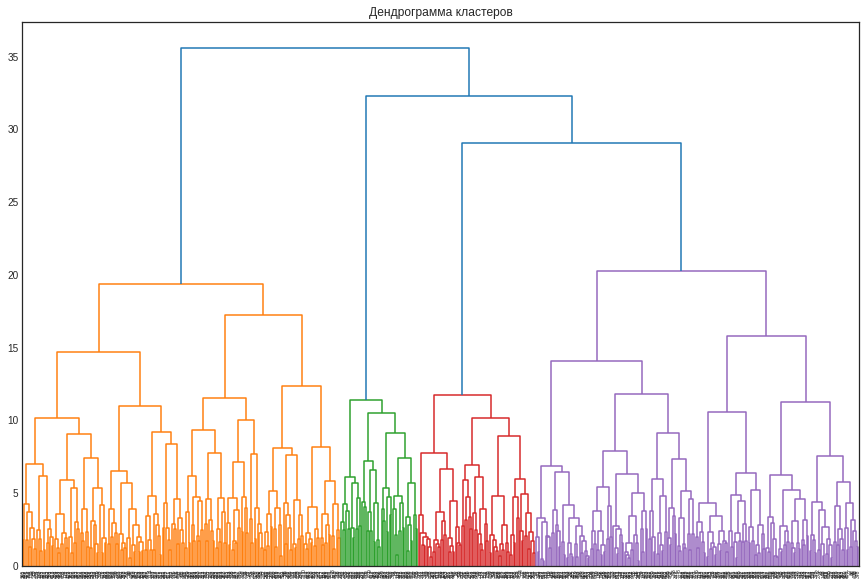

In [393]:
linked = linkage(KM_sample_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеров')
plt.show()

**Вывод:** оптимальное количество кластеров можно определить по количеству цветов на денрограмме, то есть их 4. Но по условию задачи их должно быть 5.

### Расчет значений кластеров и метрики silhouette_score <a class="anchor" id="id_4c"></a>

In [394]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(KM_sc)
# сохраняем метки кластера отдельной колонке таблицы K_data
K_data['cluster_km'] = labels

Вычисление метрики Silhouette_score для алгоритма K-mean:

In [395]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(KM_sc,labels)))

Silhouette_score: 0.13


Построение диаграмм рассеяния для колонок с небинарными значениями:

In [396]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    
    plt.legend(bbox_to_anchor=(1,1), 
               prop={'size':20}, 
               title = 'Clusters', title_fontsize='x-large')
    plt.show()

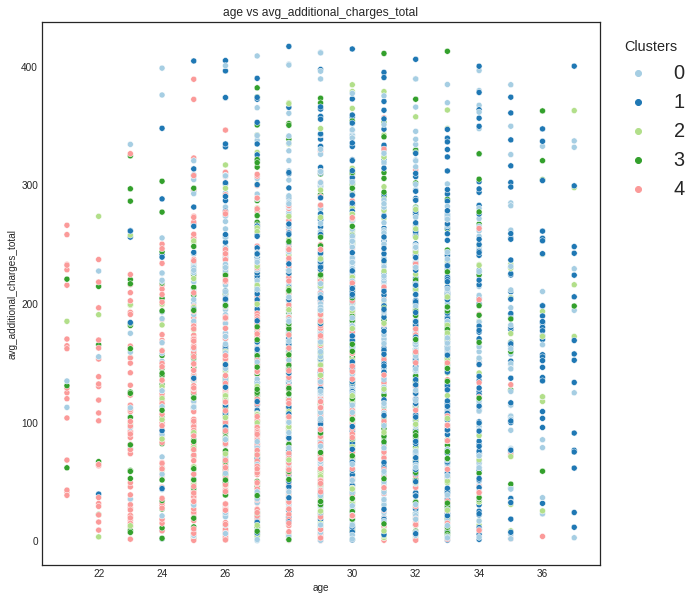

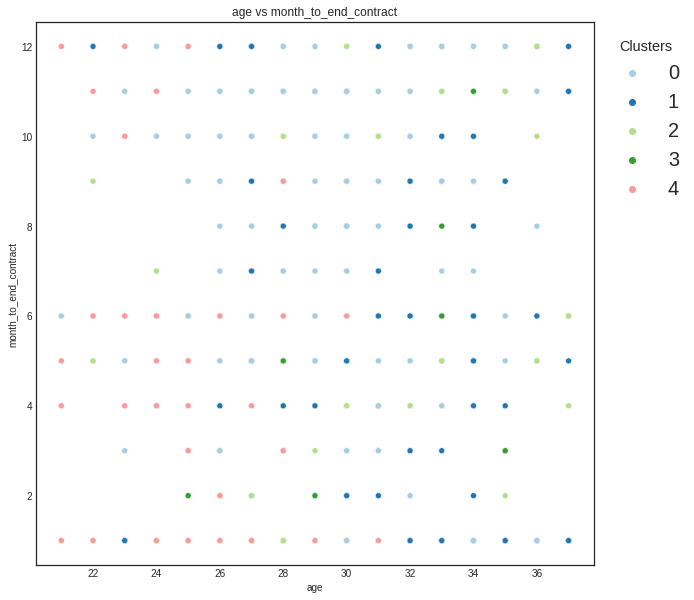

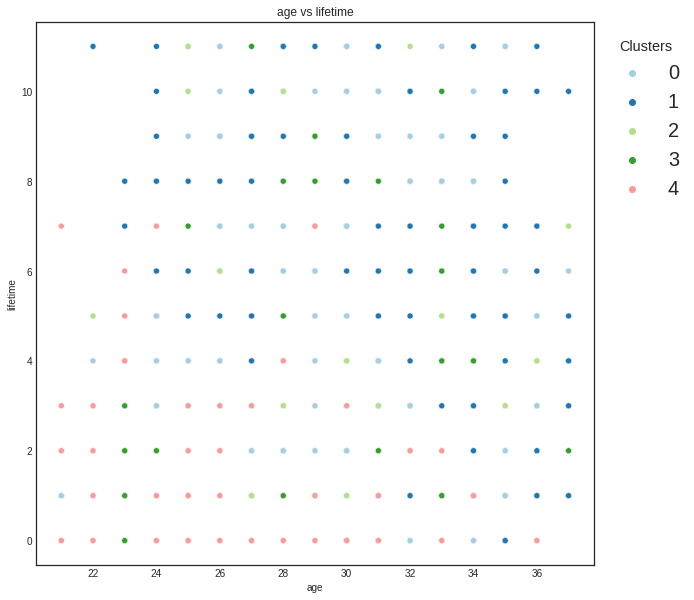

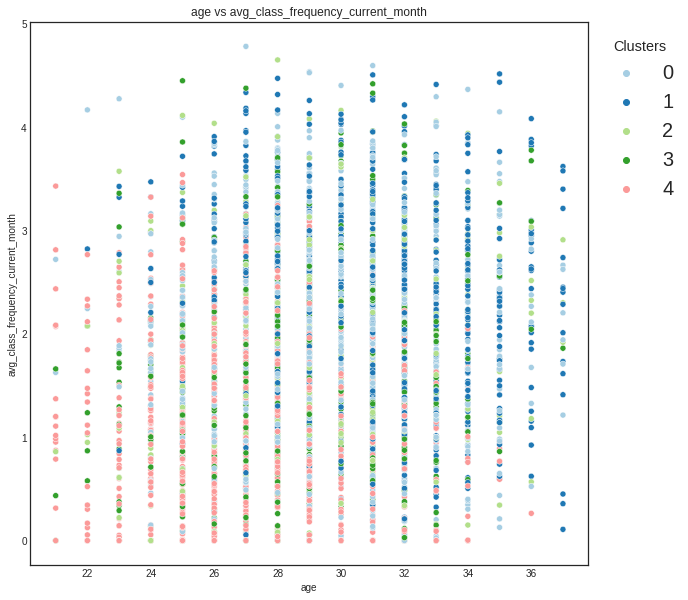

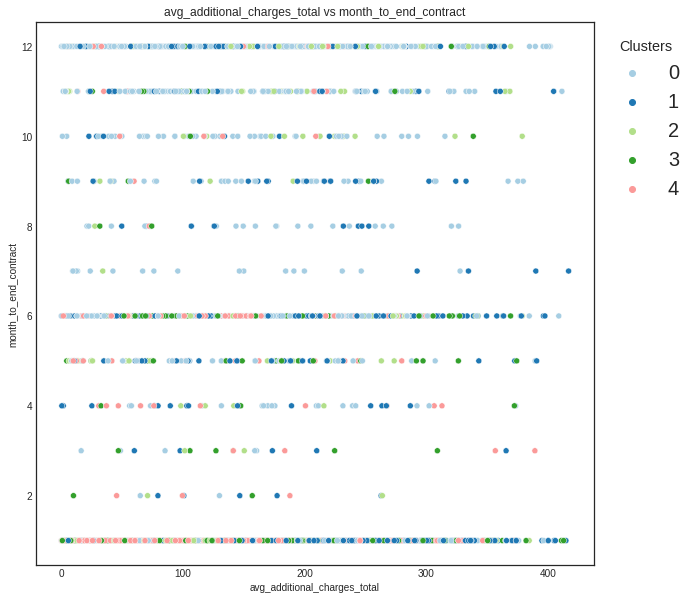

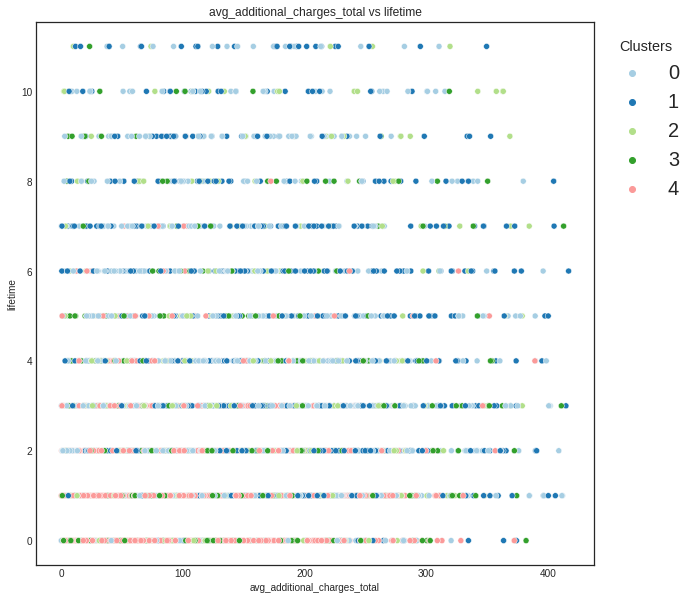

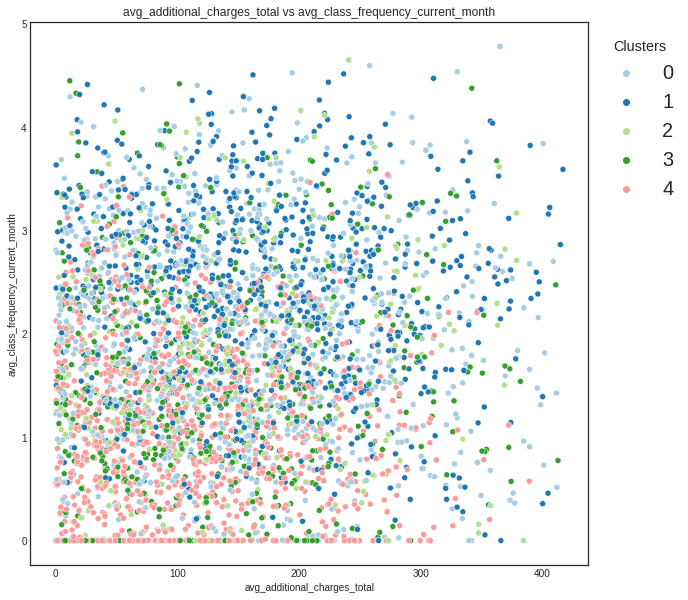

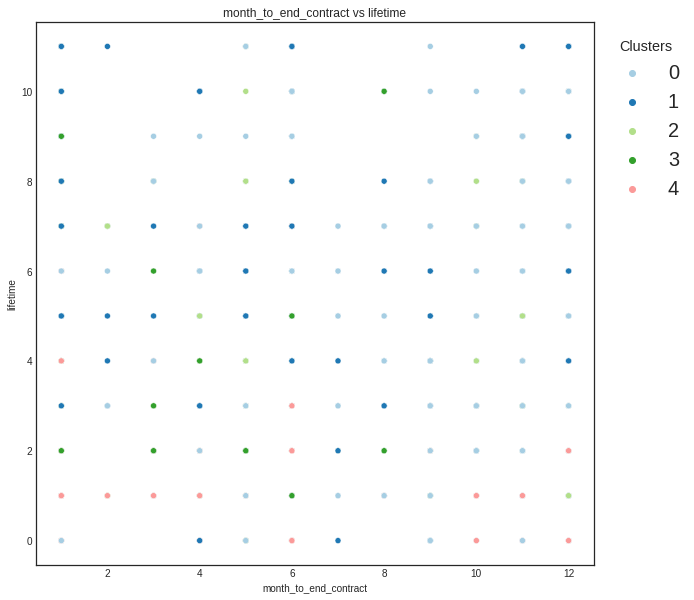

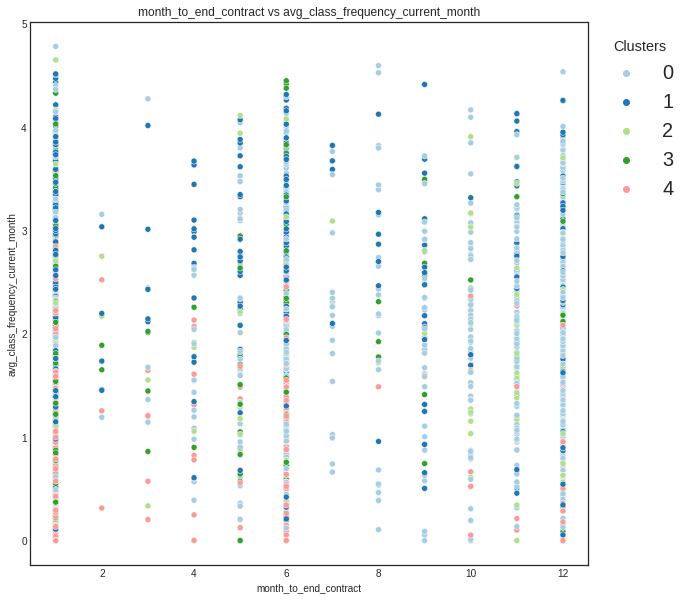

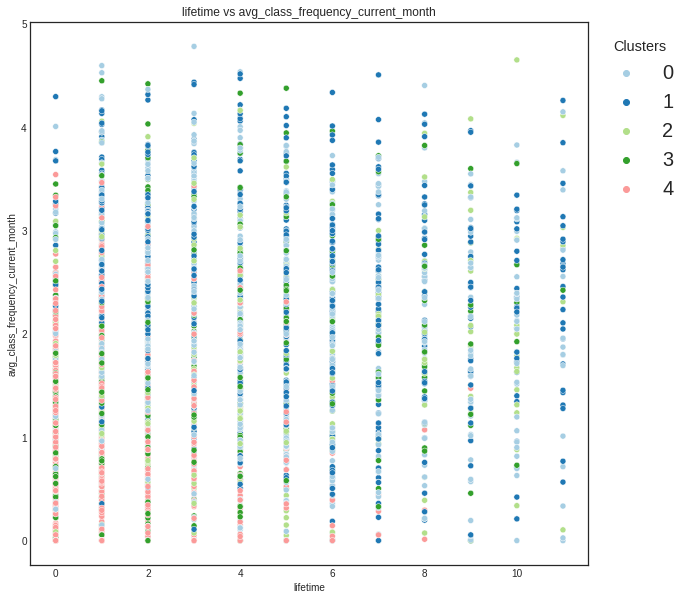

In [397]:
col_pairs = list(itertools.combinations(K_data.loc[:,K_data.columns.isin(non_binary_columns)], 2))
for pair in col_pairs:
    show_clusters_on_plot(K_data, pair[0], pair[1], 'cluster_km')

**Вывод:** диаграммы подтверждают значение silhouette_score, что четкого разделения по признакам нет.

### Вывод статистики по средним значениям  признаков по кластеру <a class="anchor" id="id_4d"></a>

In [398]:
# выводим статистику по средним значениям наших признаков по кластеру
display(K_data.groupby('cluster_km').mean().T.round(3))

cluster_km,0,1,2,3,4
gender,0.483,0.550,0.532,0.501,0.497
near_location,0.992,0.998,0.858,0.000,1.000
partner,0.952,0.188,0.476,0.490,0.282
promo_friends,0.828,0.048,0.323,0.072,0.134
phone,1.000,1.000,0.000,1.000,1.000
group_visits,0.521,0.543,0.421,0.230,0.260
age,29.661,30.778,29.228,28.758,27.380
avg_additional_charges_total,152.354,169.910,144.421,135.113,115.672
month_to_end_contract,7.511,4.010,4.510,2.693,2.010
lifetime,3.834,4.474,3.251,2.611,1.474


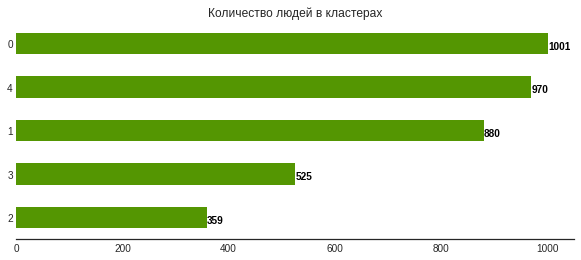

In [399]:
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) ]
fig,axes = plt.subplots(figsize=(10,4))
bar = K_data.groupby('cluster_km')['lifetime'].count().sort_values().plot(
    kind = 'barh', 
    ylabel = 'Количество', 
    xlabel='', 
    color = color,
    title = 'Количество людей в кластерах')
#Убирание рамок вложенных графиков
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False) 
# Значения данных
rects = axes.patches    
for index in range(len(rects)):   
            width = rects[index].get_width()    
            axes.text(width+0.5, rects[index].get_y()+0.2, str(round(width, 2)),
                 fontsize='medium', weight='bold', color='black',va='center',ha='left')    
plt.show()

**Описание кластеров.** 

*Кластер 1*. Включает клиентов, на которых держится бизнес. Этот кластер третий по численности, его клиенты имеют средний возраст чуть больше 30, у них есть телефон, они проживают рядом. Они не пришли по приглашению друзей, не работают в партнерских организациях, занимаются 2-3 раза в неделю, что может говорить, что они посещают именно ради сохранения физической формы и здоровья. Поэтому  от них клуб получает самые большие дополнительные доходы.  Большей частью они имеют полугодовые или месячные абонементы. Но они очень ценят свое время или требовательны, так как могут прекратить заниматься, имея проплаченный абонемент в среднем на 4 месяца вперед. Средняя продолжительность жизни в клубе такого клиента около четырех с половиной месяцев.

*Кластер 0*. Он похож на кластер 1, он самый многочисленный, но в нем  собраны клиенты пришедшие по приглашению друзей или работающие в партнерских организациях.У них средний возраст 29-30 лет. В этом кластере больше людей с годовыми и полугодовыми абонементами, меньше клиентов с месячным абонементом. Они обычно занимаются 2 раза в неделю, по-видимому из-за того, что часто ходят с друзьями и им труднее выкроить общее время. Средняя продолжительность жизни в клубе такого клиента чуть менее четырех  месяцев.

*Кластер 2*. Основной особенностью клиентов этого кластера является то, что они не указали свой телефон(видимо поэтому он самый малочисленный). Это может говорить о том, что они ценят приватность. Они живут рядом, большей частью пришли самостоятельно, занимаются 1-2 раза в неделю, также платежеспособны и охотно берут полугодовые абонементы.  

*Кластер 3*.  В нем клиенты более молодого возраста, с телефонами, но не проживающие рядом с центром. У большинства из них месячные абонементы, но есть и полугодовые, они почти не берут их на год. Они занимаются 1-2 раза в неделю. Средняя продолжительность жизни в клубе таких посетителей около двух с половиной месяцев.

*Кластер 4*. Этот кластер второй по численности и в нем самое низкое значение среднего возраста ( около 27 лет). Эти клиенты проживают рядом, имеют телефоны, в основном оформляют месячные абонементы, но занимаются в среднем  один раз в неделю. Поэтому такие клиенты приносят самые маленькие дополнительные доходы центру.  Средняя продолжительность жизни в клубе таких посетителей около полутора месяцев.
 

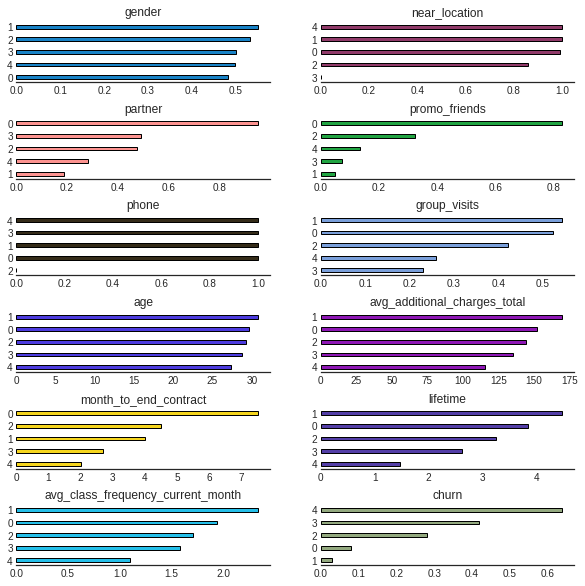

In [400]:
columns = K_data.columns.values
cols = 2 # число колонок под вложенные графики
rows = 6 # число строчек под вложенные графики
count = 0
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))
for r in range(rows):
    for c in range(cols):
            color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
            ax =K_data.pivot_table(index = 'cluster_km',
                                   values = columns[count], 
                                   aggfunc = 'mean').sort_values(columns[count]).plot(
                kind='barh',
                ax = axes[r,c],
                edgecolor='black',  
                title = f'{columns[count]}',
                color = color,
                xlabel = '', 
                width = 0.3,
                legend=False)
            #Убирание рамок вложенных графиков           
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)            
            count+=1
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

**Выводы.**   
Меньше всего склонны к оттоку кластеры в порядке 1, 0, 2, 3, 4. Такой же порядок, только уже сверху вниз мы наблюдаем у признаков avg_class_frequency_current_month, lifetime, age, avg_additional_charges_total, group_visits. То есть  средние значения этих признаков тем выше, чем меньше значение оттока у кластера. 

### Диаграмма распределения признаков по кластерам <a class="anchor" id="id_4e"></a>

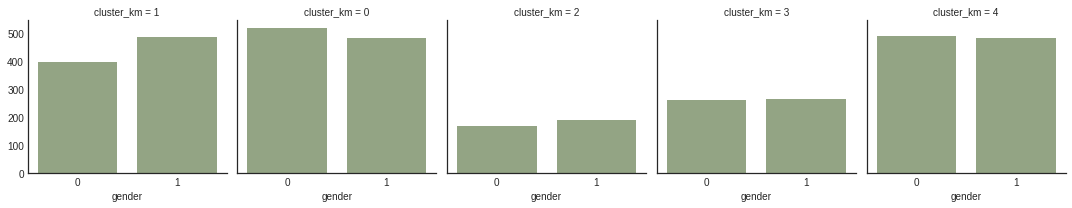

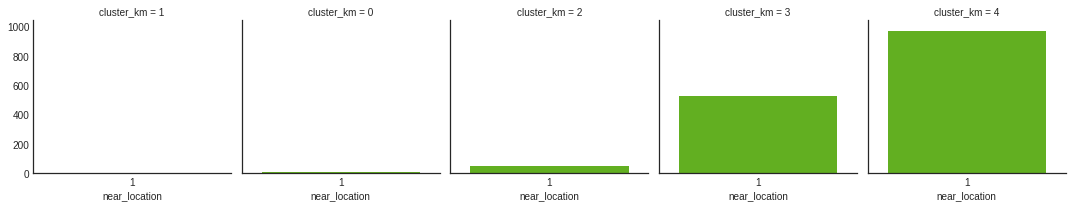

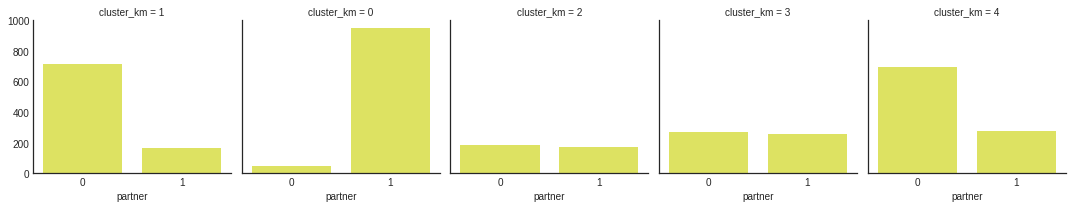

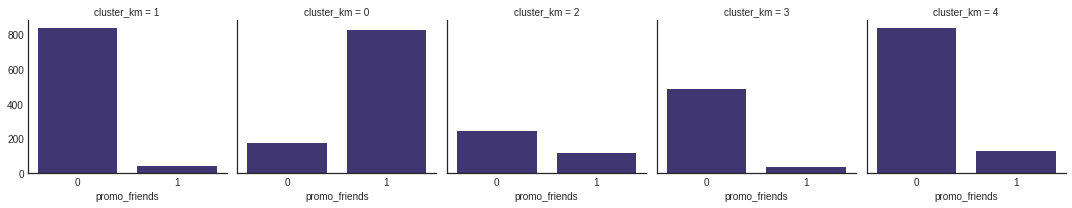

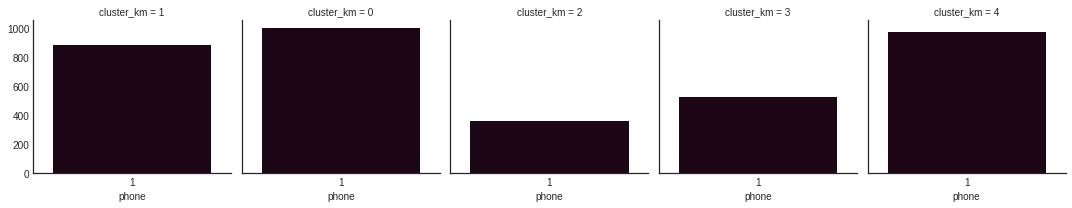

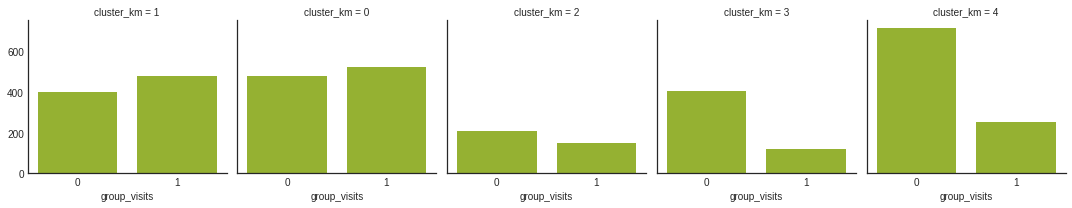

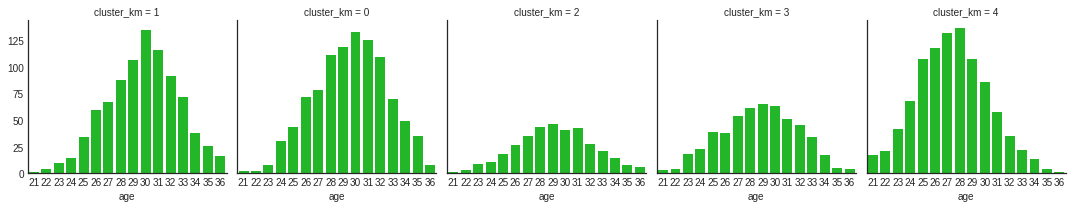

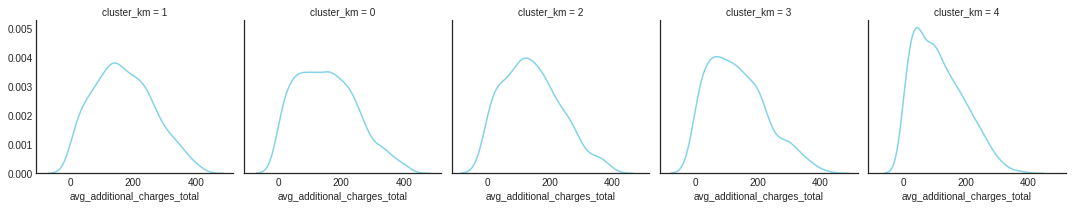

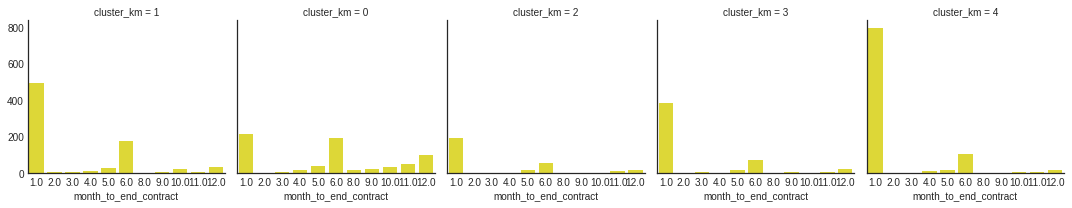

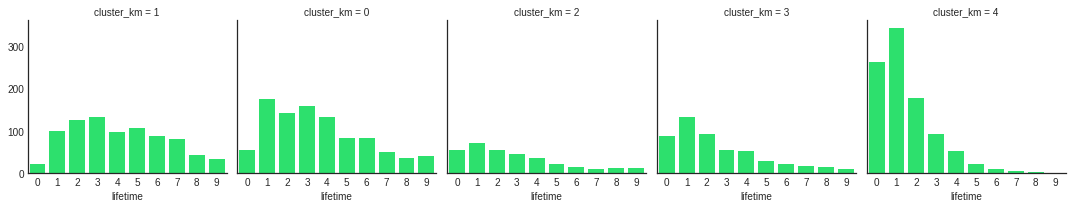

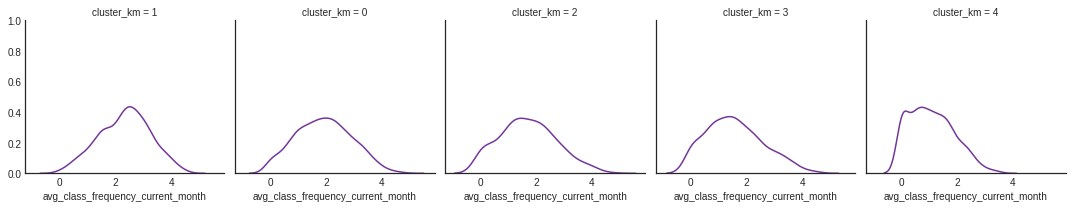

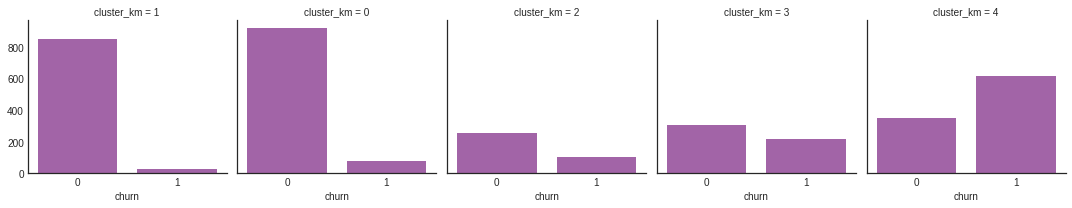

In [401]:
for column in K_data.columns[:-1]:
    grid = sns.FacetGrid(K_data,  col="cluster_km",
                         margin_titles=True, 
                         hue = 'cluster_km',
                         col_order = [1,0,2,3,4], 
                         palette = color)
    if column == 'avg_additional_charges_total':
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        grid.map(sns.kdeplot, column)
    elif column == 'avg_class_frequency_current_month':
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        grid.map(sns.kdeplot, column)
        plt.ylim(0, 1)
    else:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]        
        grid.map(sns.countplot, column);

**Выводы:**  из предыдущего графика была выявлена последовательность кластеров в порядке увеличения параметра churn - 1, 0, 2, 3, 4. Этот график по большей части подтверждает выводы того графика. Можно добавить, что:  
 - в кластере 4 подрастает количество женщин, чем в кластере 1;
 - увеличивается количество посетителей, пришедших не по приглашению друзей и, косвенно, реже занимающихся в группах, в последних кластерах;
 - параметр возраста имеет нормальное распределение и в кластерах 1, 0 среднее ближе к 30 годам, тогда как в кластере 4 ближе к 27-28 годам, что может говорить о том, что более молодые люди более склонны менять центры или прекращать занятия;
 - параметр additional_charges_total также носит характер нормального распределения и смещается в сторону меньших значений по мере последовательности кластеров;
 - параметр avg_class_frequency_current_month смещается со значения 2 к нулевой отметке по мере последовательности кластеров;
 - в последних кластерах практически нет годовых абонементов.

## Выводы и рекомендации по снижению параметра оттока клиентов <a class="anchor" id="id_5"></a>

### Выводы

1. Таблица данных, предназначенная для построения моделей имеет следующие параметры:
 - женщин и мужчин примерно поровну, последних чуть больше;
 - по возрасту, подавляющее большинство участников имеют от 25 до 35 лет, минимальный -18 лет, максимальный - 41 год;
 - примерно 85% людей проживают или работают в оодном районе с фитнесс-центром;
 - партнеров и не партнеров примерно поровну, последних чуть меньше, примерно 30% людей записались в центры по промо-акциям "Приведи друга";
 - более половины (около 2300) участников посещают фитнесс-центры по месячному абонементу, чуть менее 1000 - по годовому абонементу, остальные - по шестимесячному;
 - средний дополнительный доход фитнесс-центра у 75% у посетителей равен 211 рублям, максимальное значение 552 рубля;
 - более половины (около 2400) людей имеют абонемент, который закончится в следующем месяце, среднее количество месяцев до окончания абонемента - 4.3 месяца;
 - 50% посетителей прекращают занятия после 3 месяцев, среднее значение по всем данным - 3.7 месяцев;
 - 2 или 3 посещения в неделю - самые распространенное количество посещений в неделю;
 - Среднее значение оттока посетителей в месяц составляет 26%.  
   
2. Метрики модели Logistic Regression: Accuracy = 0.90, Precision = 0.82, Recall = 0.81, F1 = 0.81.
3. Метрики модели Random Forest: Accuracy = 0.906, Precision = 0.851, Recall = 0.782, F1 = 0.815.
4. Ключевой метрикой для прогнозирования оттока является Recall и по этой метрике модель Logistic Regression лучше на 3%.
5. Оптимальным количеством кластеров для модели K-means будет число 4.
6. Лучшими клиентами для фитнес-центров будут клиенты в кластерах 0 и 1. Эти кластеры  входят в тройку самых многочисленных.
7. Оптимальными клиентами согласно этим кластерам будут люди около 30 лет, мужчины или женщины, желательно имеющие различные бонусы в виде партнерских программ, желательно посещающие групповые занятия, имеющие длительные абонементы 6 или 12 месяцев, приносящие доход близко к 200 рублям.
8. Снижение частоты посещения занятий в неделю в последний месяц вкупе с месячным абонементом является явным признаком предстоящего прекращения занятий.

### Рекомендации

1. Так как уменьшение количества занятий в неделю сигнализирует предстоящем прекращении посещений следует наладить рассылку электронных писем тем клиентам, у которых появились эти тревожные сигналы, предлагающие не прерывать занятия для укрепления здоровья.
2. Также следует вести учет посетителей, которые занимаются вместе с друзьями: если у друзей также появились признаки снижения активности, это может повлечь уход второго, поэтому следует следовать вышестоящей рекомендации.  
3. Кластеры 1 и 0 являются основными клиентами центра, на которых держится его бизнес. Таким посетителям следует предлагать абонементы на более длительный срок и желательно с автоматической оплатой, так как одно дело, когда деньги снимаются с кредитной карты автоматически, другое дело, когда человек лично считает деньги для оплаты и тем самым переоценивает выгодность занятий для себя каждый платежный период(согласно данным - каждый месяц).
4. Чтобы сохранить клиентов из второго кластера, нужно найти особый подход. Поменьше надоедать электронными письмами и поддерживать комфортную атмосферу в клубе, можно предложить услуги личного тренера или годовой абонемент со скидкой за первую оплату.